# Combining Data sets

This analysis shows how to combine multiple datasets and build a model to predict the salary of various football coaches. The report contains 5 sections; combining data sets, munging and feature engineering, visualizations, modeling, and analysis and recommendations. 

The process for combining each data set is as followed. Initially, I start with a coaches dataset. This has 129 observations containing school name, conference, coach and pay. I combine an additional 3 data sets to make a total of 4 datasets in this analysis. Combining these additional datasets introduces some issues that need to be addressed. The school names across each dataset are different. To merge them they need to have consistent names in order to join them using merging in pandas. 

In order to solve this issue I use a combination of regular expressions and simply replacing values. This process is a good start but it does not match all observations. To overcome this I use a package called fuzzywuzzy. This package can calculate similarity between words. I use it to match the remainder of the mismatched observations. For example, it is able to match observations like;

miami (fla.) and miami (florida)


Finally, the dataset is expanded to include 4 datasets. The coaches dataset, data on graduation rates, school athletic records and ranking, data on stadium capacity and year opened. 

In [ ]:
pip install fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import re
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

In [ ]:
#load coaches data, view shape, col names, and some preprocessing
coachDF = pd.read_csv('https://raw.githubusercontent.com/RonenReouveni/IST_718_lab1/main/Coaches9.csv')
print(coachDF.shape)
coachDF['School'] = coachDF['School'].str.lower()
coachDF.head()

(129, 9)


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,air force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,alabama at birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,appalachian state,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


In [ ]:
#Replace the mismatched names from the capacity dataset to match the coaches dataset
#replace the values and then lowercase
closedNames = ['SMU', 'UAB','BYU', 'UNC Charlotte', 'UMass','Miami','Miami-OH'
              ,'UNLV','NC State','USC','Southern Miss','TCU','UTEP','UTSA']


openNames = ['southern methodist','alabama at birmingham','brigham young', 'charlotte'
            ,'massachusetts','miami (fla.)','miami (ohio)','nevada-las vegas','north carolina state'
            ,'southern california','southern mississippi','texas christian','texas-el paso','texas-san antonio']


#https://www.collegegridirons.com/comparisons/

stadSize = pd.read_csv('https://raw.githubusercontent.com/RonenReouveni/IST_718_lab1/main/wpdt_export.csv')
stadSize['College'] = stadSize['College'].replace(closedNames,openNames)
stadSize['College'] = stadSize['College'].str.lower()


merged_left = pd.merge(left=coachDF, right=stadSize, how='left', left_on='School', right_on='College')
merged_left.head()

,School,Conference_x,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,College,Conference_y,Capacity,Opened
0,air force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,air force,Mountain West,"46,692",1962
1,akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,akron,MAC,"30,000",2009
2,alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,alabama,SEC,"100,077",1929
3,alabama at birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,alabama at birmingham,CUSA,"71,000",1927
4,appalachian state,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,appalachian state,Sun Belt,"30,000",1962


In [ ]:
#https://web3.ncaa.org/aprsearch/gsrsearch
#load in graduation data and rename the columns 
gradRate = pd.read_csv('https://raw.githubusercontent.com/RonenReouveni/IST_718_lab1/main/grads.csv', header=None)
names = ['cohort','School_name','Conf','Sport','St','GSR','FGR','None','None1']
gradRate = gradRate.set_axis(names, axis=1)


#munge names so they match in both datasets
merged_left['School'] = merged_left['School'].str.strip() #get rid of white space

#expand names 
gradRate['School_name'] = gradRate['School_name'].str.replace('U.S. Air Force Academy','air force')
gradRate['School_name'] = gradRate['School_name'].str.replace('Georgia Institute of Technology','georgia tech')
gradRate['School_name'] = gradRate['School_name'].str.replace('U.S. Naval Academy','navy')
gradRate['School_name'] = gradRate['School_name'].str.replace('The University of Southern Mississippi','southern mississippi')
gradRate['School_name'] = gradRate['School_name'].str.replace('Pennsylvania State University','penn state')
gradRate['School_name'] = gradRate['School_name'].str.replace('The Ohio State University','ohio state')
gradRate['School_name'] = gradRate['School_name'].str.replace('University of Nevada, Reno','Reno')	
gradRate['School_name'] = gradRate['School_name'].str.replace('California State University, Fresno','Fresno state') 
gradRate['School_name'] = gradRate['School_name'].str.replace('University at Buffalo, the State University of New York','Buffalo') 
gradRate['School_name'] = gradRate['School_name'].str.replace('Virginia Polytechnic Institute and State University','Virginia tech') 
gradRate['School_name'] = gradRate['School_name'].str.replace('University of California, Los Angeles','ucla') 
gradRate['School_name'] = gradRate['School_name'].str.replace('The University of Tulsa','tulsa') 
gradRate['School_name'] = gradRate['School_name'].str.replace('Middle Tennessee State University','Middle Tennessee') 
gradRate['School_name'] = gradRate['School_name'].str.replace('Bowling Green State University','Bowling Green') 
gradRate['School_name'] = gradRate['School_name'].str.replace('University of Illinois Urbana-Champaign','Illinois') 
gradRate['School_name'] = gradRate['School_name'].str.replace('University of Louisiana at Lafayette','louisiana-lafayette')
gradRate['School_name'] = gradRate['School_name'].str.replace('University of Texas at El Paso','texas-el paso') 
gradRate['School_name'] = gradRate['School_name'].str.replace('University of Nevada, Las Vegas','nevada-las vegas') 



#lowercase everything
gradRate['School_name'] = gradRate['School_name'].str.lower()

#general changes to match more values
gradRate['School_name'] = gradRate['School_name'].str.replace('university','')
gradRate['School_name'] = gradRate['School_name'].str.replace('of','')
gradRate['School_name'] = gradRate['School_name'].str.replace('louisiana state','lsu')


#REGEX all strings after ',' must be removed
regex_pat = re.compile(r'\,.*$', flags=re.IGNORECASE)
gradRate['School_name'] = gradRate['School_name'].str.replace(regex_pat, '')

#strip whitespace 
gradRate['School_name'] = gradRate['School_name'].str.strip()

In [ ]:
#put keys of each data set into a list 
#now we can find the rest of the mismatched keys
list1 = list(merged_left['School'])
list2 = list(gradRate['School_name'])
c = [ element for element in list1 if element not in list2] 
d = [ element for element in list2 if element not in list1]


#let fuzzy wuzzy match more names
#if it finds a match it coerces it to match names
#see the print for how it can match things like:
#miami (fla.) with miami (florida)
for string in c:
  for otherString in d:
    Ratio = fuzz.ratio(string,otherString)
    if Ratio>80:
      gradRate.School_name[gradRate.School_name == otherString] = string
      print(string, otherString)

louisiana-monroe louisiana monroe
miami (fla.) miami (florida)
miami (ohio) miami  (ohio)


In [ ]:
#match some stragglers
gradRate.School_name[gradRate.School_name == 'wisconsin-madison'] = 'wisconsin'
gradRate.School_name[gradRate.School_name == 'texas southern'] = 'texas'


#merge them and match on name again
#we should end up with 23 columns
merged_left_ = pd.merge(left=merged_left, right=gradRate, how='left', left_on='College', right_on='School_name')


merged_left_.drop(['None','None1'], axis=1, inplace=True)
print(merged_left_[merged_left_.isna().any(axis=1)].shape)


merged_left_.head()

(9, 21)


,School,Conference_x,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Stadium,College,Conference_y,Capacity,Opened,cohort,School_name,Conf,Sport,St,GSR,FGR
0,air force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,Falcon Stadium,air force,Mountain West,"46,692",1962,2006.00,air force,Mountain West Conference,Football,CO,93.00,nan
1,akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",InfoCision Stadium,akron,MAC,"30,000",2009,2006.00,akron,Mid-American Conference,Football,OH,58.00,52.00
2,alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",Bryant Denny Stadium,alabama,SEC,"100,077",1929,2006.00,alabama,Southeastern Conference,Football,AL,73.00,57.00
3,alabama at birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",Legion Field,alabama at birmingham,CUSA,"71,000",1927,2006.00,alabama at birmingham,Conference USA,Football,AL,60.00,55.00
4,appalachian state,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",Kidd Brewer Stadium,appalachian state,Sun Belt,"30,000",1962,2006.00,appalachian state,Southern Conference,Football,NC,68.00,56.00


In [ ]:
#load in win, loss, rank, football stats dataset
records = pd.read_csv('https://raw.githubusercontent.com/RonenReouveni/IST_718_lab1/main/schoolRecords.csv', sep='\t')

#match what records we can by expanding st to state etc. 
records['Name'] = records['Name'].str.strip()
records['Name'] = records['Name'].str.lower()

#important to note here:
#this can cause some weirdness but fuzzymatch overcomes all
records['Name'] = records['Name'].str.replace("st.",'state')
records['Name'] = records['Name'].str.replace('ala.','alabama')


records['Name'] = records['Name'].str.strip()

records.head()


,Rank,Name,Games,Plays,Yds,Avg,TDs,Ydspgm,Wins,Losses,Ties
0,1,louisiana tech,12,1054,6935,6.58,84,577.92,9,3,0
1,2,baylor,13,1072,7439,6.94,76,572.23,8,5,0
2,3,texas a&m,13,1025,7261,7.08,78,558.54,11,2,0
3,4,oklahoma state,13,1014,7111,7.01,73,547.00,8,5,0
4,5,oregon,13,1058,6986,6.60,89,537.38,12,1,0


In [ ]:
#find mismatched names
list1 = list(merged_left_['School'])
list2 = list(records['Name'])
c = [ element for element in list1 if element not in list2] 
d = [ element for element in list2 if element not in list1]

#match using fuzzy wuzzy
for string in c:
  for otherString in d:
    Ratio = fuzz.ratio(string,otherString)
    if Ratio>85:
      records.Name[records.Name == otherString] = string
      print(string, otherString)

boston college bostaten college
east carolina eastatecarolina
miami (fla.) miami (fl)
miami (ohio) miami (oh)
northwestern northwestatern
stanford statenford
west virginia westatevirginia


In [ ]:
#recalculate and rematch again
list1 = list(merged_left_['School'])
list2 = list(records['Name'])
c = [ element for element in list1 if element not in list2] 
d = [ element for element in list2 if element not in list1]

for string in c:
  for otherString in d:
    Ratio = fuzz.ratio(string,otherString)
    if Ratio>75:
      records.Name[records.Name == otherString] = string
      print(string, otherString)

alabama alabamaama
central michigan central mich.
eastern michigan eastatern mich.
florida atlantic fla. atlantic
middle tennessee middle tenn.
northern illinois northern ill.
south florida south fla.
southern mississippi southern miss.
western michigan westatern mich.


In [ ]:
#finally do this a 3rd time
list1 = list(merged_left_['School'])
list2 = list(records['Name'])
c = [ element for element in list1 if element not in list2] 
d = [ element for element in list2 if element not in list1]

for string in c:
  for otherString in d:
    Ratio = fuzz.ratio(string,otherString)
    if Ratio>65:
      records.Name[records.Name == otherString] = string
      print(string, otherString)

houston houstaten
louisiana-lafayette la.-lafayette
louisiana-monroe la.-monroe
western kentucky westatern ky.


In [ ]:
closedNames = ['byu' ,'uab','unlv','mississippi state',
               'smu','utsa','utep','tcu','ucf','fiu','georgia state']



openNames = ['brigham young','alabama at birmingham','nevada-las vegas'
             ,'mississippi','southern methodist','texas-san antonio'
             ,'texas-el paso','texas christian','central florida'
             ,'florida international','georgia']


records['Name'] = records['Name'].replace(closedNames, openNames)


finalMerge = pd.merge(left=merged_left_, right=records, how='left', left_on='School', right_on='Name')
finalMerge = finalMerge.drop(['Bonus','BonusPaid','Buyout','TotalPay','Plays','cohort','School_name','College'
                                ,'Conference_y','Sport','Name','Avg','Conf','AssistantPay'
                                ,'Ties','Stadium'], axis = 1)
finalMerge.head()

,School,Conference_x,Coach,SchoolPay,Capacity,Opened,St,GSR,FGR,Rank,Games,Yds,TDs,Ydspgm,Wins,Losses
0,air force,Mt. West,Troy Calhoun,885000,"46,692",1962,CO,93.00,nan,51.00,13.00,5445.00,49.00,418.85,6.00,7.00
1,akron,MAC,Terry Bowden,"$411,000","30,000",2009,OH,58.00,52.00,45.00,12.00,5126.00,41.00,427.17,1.00,11.00
2,alabama,SEC,Nick Saban,"$8,307,000","100,077",1929,AL,73.00,57.00,31.00,14.00,6237.00,71.00,445.50,13.00,1.00
3,alabama at birmingham,C-USA,Bill Clark,"$900,000","71,000",1927,AL,60.00,55.00,50.00,12.00,5029.00,43.00,419.08,3.00,9.00
4,appalachian state,Sun Belt,Scott Satterfield,"$712,500","30,000",1962,NC,68.00,56.00,nan,nan,nan,nan,nan,nan,nan


# Munging and Feature Engineering

Feature engineering is shown to be one of the most vital portions of this analysis. After fixing data types, I create four new predictors. Discretized year opened, power status, log school pay, and log capacity. Year opened is the year the stadium at the school was created. Below, I turn year opened into a categorical variable with five buckets spanning roughly 20 years each. 

In college football there are many conferences. However, 5 of these conferences are considered elite. These are the ACC, Big Ten, Big 12, SEC, and Pac-12. A new categorical predictor is made indicating if a school is part of one of these conferences. To be in one of these schools is to be a member of the Power 5. Much of the analysis will show how important Power 5 status is.

Baylor, BYU, Rice, and SMU all have coaches salary missing and are therefore dropped. However, the missing data for Wins and GSR will be replaced with the group mean of the conference that the school falls into. 

In [ ]:
#munge
finalMerge['SchoolPay'] = finalMerge['SchoolPay'].str.replace('$', '')
finalMerge['SchoolPay'] = finalMerge['SchoolPay'].str.replace(',', '')
finalMerge['SchoolPay'] = finalMerge['SchoolPay'].replace('--', np.nan)

finalMerge['SchoolPay'] = finalMerge['SchoolPay'].astype('float') 

finalMerge['Capacity'] = finalMerge['Capacity'].str.replace(',', '')
finalMerge['Capacity'] = finalMerge['Capacity'].astype('float') 

In [ ]:
#must drop these 4 rows
print(finalMerge[finalMerge['SchoolPay'].isnull()]['School'])
finalMerge = finalMerge.dropna(subset=['SchoolPay'])
finalMerge['SchoolPay'].isna().sum()

13                 baylor
17          brigham young
93                   rice
101    southern methodist
Name: School, dtype: object


0

In [ ]:
#replace NA with conditional means
print(finalMerge[finalMerge['Wins'].isnull()]['School'])
finalMerge['Wins'] = finalMerge['Wins'].fillna(finalMerge.groupby('Conference_x')['Wins'].transform('mean'))
print(finalMerge['Wins'].isna().sum())

#replace NA with conditional means
print(finalMerge[finalMerge['GSR'].isnull()]['School'])
finalMerge['GSR'] = finalMerge['GSR'].fillna(finalMerge.groupby('Conference_x')['GSR'].transform('mean'))
finalMerge['GSR'].isna().sum()

4     appalachian state
23            charlotte
26     coastal carolina
39     georgia southern
40        georgia state
52              liberty
69    mississippi state
87         old dominion
Name: School, dtype: object
0
10                  army
23             charlotte
40         georgia state
73                nevada
97         south alabama
112    texas-san antonio
Name: School, dtype: object


0

In [ ]:
#discretize opening year
openBucket = []

for val in finalMerge["Opened"]:
  if val < 1930:
    openBucket.append('1904-1930')
  elif val < 1950:
    openBucket.append('1930-1950')
  elif val < 1970:
    openBucket.append('1950-1970')
  elif val < 1990:
    openBucket.append('1970-1990')
  else:
    openBucket.append('1990-2017')

finalMerge['Opened'] = openBucket
finalMerge['Opened'] = finalMerge['Opened'].astype("category").cat.reorder_categories(['1904-1930', '1930-1950','1950-1970', '1970-1990', '1990-2017'])

In [ ]:
#lets add a new column with the combined categories 
confList = list(finalMerge['Conference_x'])

for index, item in enumerate(confList):
  if item == 'ACC' or item == 'Big Ten' or item == 'Big 12' or item == 'SEC' or item == 'Pac-12':
    confList[index] = 'Power5'
  else:
    confList[index] = 'notPower'

finalMerge['Power'] = confList
finalMerge.head()

,School,Conference_x,Coach,SchoolPay,Capacity,Opened,St,GSR,FGR,Rank,Games,Yds,TDs,Ydspgm,Wins,Losses,Power
0,air force,Mt. West,Troy Calhoun,885000.00,46692.00,1950-1970,CO,93.00,nan,51.00,13.00,5445.00,49.00,418.85,6.00,7.00,notPower
1,akron,MAC,Terry Bowden,411000.00,30000.00,1990-2017,OH,58.00,52.00,45.00,12.00,5126.00,41.00,427.17,1.00,11.00,notPower
2,alabama,SEC,Nick Saban,8307000.00,100077.00,1904-1930,AL,73.00,57.00,31.00,14.00,6237.00,71.00,445.50,13.00,1.00,Power5
3,alabama at birmingham,C-USA,Bill Clark,900000.00,71000.00,1904-1930,AL,60.00,55.00,50.00,12.00,5029.00,43.00,419.08,3.00,9.00,notPower
4,appalachian state,Sun Belt,Scott Satterfield,712500.00,30000.00,1950-1970,NC,68.00,56.00,nan,nan,nan,nan,nan,6.33,nan,notPower


In [ ]:
finalMerge['SchoolPay_log'] = np.log(finalMerge['SchoolPay'])
finalMerge['Capacity_log'] = np.log(finalMerge['Capacity'])

# Viz and EDA

Visualization and EDA will help serve as the main way to drive the direction of analysis. By finding patterns at this stage, it will benefit us in the modeling phase. 

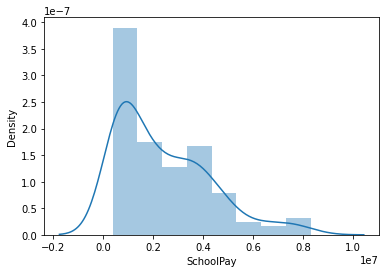

In [ ]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=finalMerge["SchoolPay"], hist=True)

Although this is a simple visualization of the distribution of school pay. It shows that school pay is not normally distributed at all. However, it serves as a baseline to show that when we split school pay by group it becomes more normally distributed. This indicates that the group a school falls in will be a critical predictor. 

In [ ]:
finalMerge.Power.value_counts()
#but how similar are these groups?

Power5      65
notPower    62
Name: Power, dtype: int64

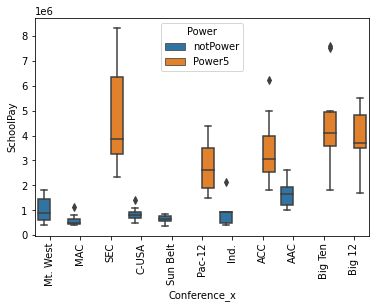

In [ ]:
ax = sns.boxplot( x='Conference_x', y='SchoolPay', data=finalMerge, hue='Power')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

This boxplot shows a coaches pay given the conference they are in. There is added insight here that encodes if a school is considered in the Power5 with color. As we can see, this clearly shows there is a significant difference between being a Power5 school or not. 

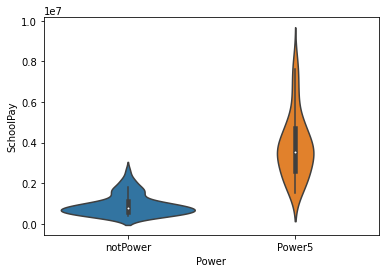

In [ ]:
ax = sns.violinplot( x='Power', y='SchoolPay', data=finalMerge)
plt.show()

To confirm the idea that Power 5 status will play a key role we can continue to explore this idea. This visualization shows the violin plot for school pay given the Power 5 group status. It reinforces a clear separation. 

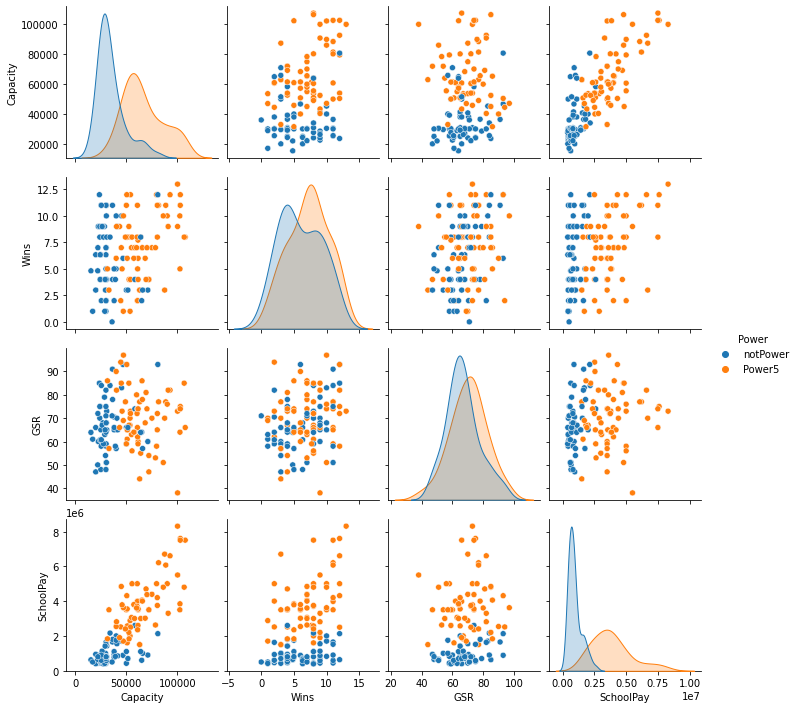

In [ ]:
finalMerge_2 = finalMerge[['Power','Capacity','Wins','GSR','SchoolPay']]
sns.pairplot(finalMerge_2, hue="Power")

This pairs plot again separates Power 5 group status. It shows a subset of the data which I believe to be relevant predictors. Other than Power 5 status, all the data in this visualization is continues. It highlights some key features. Firstly, on the bottom right we can see that the distributions of school pay given Power 5 status are very different. This is also evident in capacity. What is interesting is that Wins has a clear trend for Power5 schools but not for non Power 5 schools. This will be further explored below. Finally, GSR seems to have no impact on school pay at all. The distributions between Power 5 and non Power 5 schools is almost identical, furthermore, there seems to be no relationship between GSR and coaches pay either. 

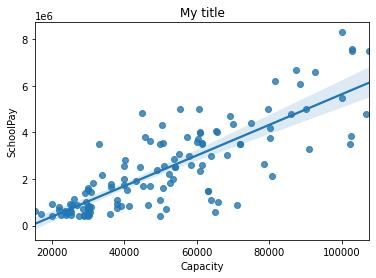

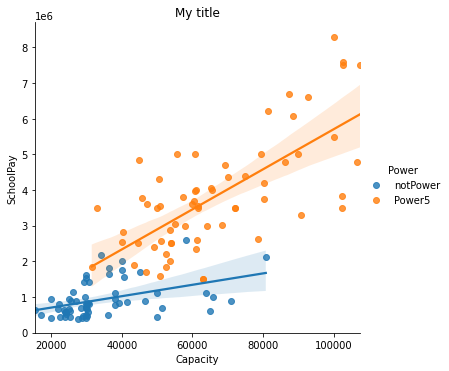

In [ ]:
sns.regplot(x=finalMerge["Capacity"], y=finalMerge["SchoolPay"])
plt.title('My title')
plt.show()

x = sns.lmplot(x="Capacity", y="SchoolPay", hue="Power", data=finalMerge)
plt.title('My title')
plt.show()

These two plots show the relationship between capacity and school pay. However, the second plot contains two separate trend lines and colors based on Power 5 status. The first plot looks to have some heteroskedasticity, as capacity increases the errors increase. Despite this there is a clear linear relationship. However, when we control for Power 5 status and use two trend lines, one for each group, the heteroskedasticity seems to disappear. We can also see that there is distinctly two different slopes for each group. This is important to understand at this stage as it will guide the modeling phase. 


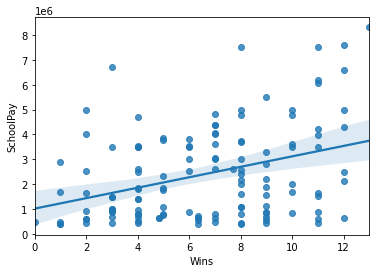

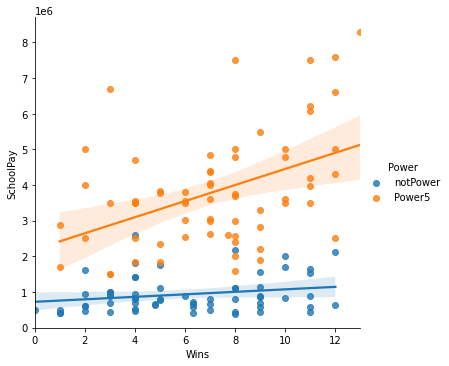

In [ ]:
sns.regplot(x=finalMerge["Wins"], y=finalMerge["SchoolPay"])
plt.show()

sns.lmplot(x="Wins", y="SchoolPay", hue="Power", data=finalMerge)
plt.show()

These visualizations also highlight how a predictor that seems to have a low correlation with coaches pay can come alive when controlling for Power 5 membership. The first graph shows that there is a weak positive correlation with wins and school pay. However, once we control for the Power 5 membership the relationship becomes more apparent. For the Power 5 schools, there is a definite relationship between winning and a coaches pay. However, for the non Power 5 schools, winning seems less important.

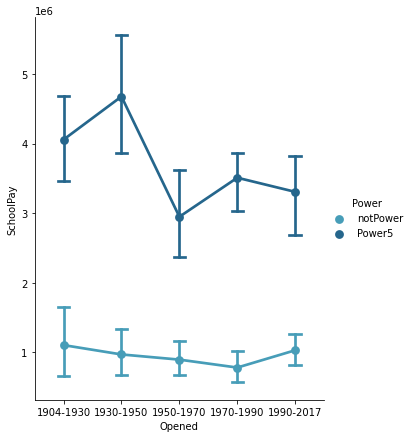

In [ ]:
# Draw a pointplot to show pulse as a function of three categorical factors
#order the opened 
g = sns.catplot(x="Opened", y="SchoolPay", hue="Power",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=finalMerge)

This visualization shows the range of coaches pay given the year the stadium was opened. It is also separated by Power 5 status. It shows that schools, especially power 5 ones, with older stadiums tend to have a higher coaches salary. However, this does not mean that opening year will be a quality predictor in our model. 

In [ ]:
corr = finalMerge.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,SchoolPay,Capacity,GSR,FGR,Rank,Games,Yds,TDs,Ydspgm,Wins,Losses,SchoolPay_log,Capacity_log
SchoolPay,1.00,0.82,0.20,0.12,-0.08,0.24,0.14,0.21,0.07,0.36,-0.35,0.93,0.79
Capacity,0.82,1.00,0.09,-0.01,-0.11,0.18,0.14,0.18,0.11,0.28,-0.27,0.79,0.97
GSR,0.20,0.09,1.00,0.84,0.05,0.19,0.01,0.04,-0.06,0.26,-0.25,0.25,0.12
FGR,0.12,-0.01,0.84,1.00,0.02,0.14,0.01,0.01,-0.04,0.16,-0.16,0.17,0.02
Rank,-0.08,-0.11,0.05,0.02,1.00,-0.38,-0.94,-0.82,-0.96,-0.53,0.53,-0.07,-0.09
Games,0.24,0.18,0.19,0.14,-0.38,1.00,0.58,0.60,0.34,0.73,-0.62,0.22,0.15
Yds,0.14,0.14,0.01,0.01,-0.94,0.58,1.00,0.91,0.96,0.66,-0.63,0.11,0.12
TDs,0.21,0.18,0.04,0.01,-0.82,0.60,0.91,1.00,0.84,0.75,-0.73,0.17,0.15
Ydspgm,0.07,0.11,-0.06,-0.04,-0.96,0.34,0.96,0.84,1.00,0.52,-0.53,0.05,0.09
Wins,0.36,0.28,0.26,0.16,-0.53,0.73,0.66,0.75,0.52,1.00,-0.99,0.32,0.24


The correlation matrix offers us deep insight into how our predictors might be chosen. Firstly, capacity has by far the highest correlation with School Pay. This will most likely be an important predictor. However, this plot does not include categorical variables, we showed above with visualization how conference and power status will also play a huge role. Wins and Losses are also correlated with School Pay, although it is only .35, this may also serve as a predictor. What is important to note here is that predictors such as Yds, TDs, Wins and Losses are all extremely correlated with each other. In all likelihood only one of these predictors will be used. 


In [ ]:
#view conditional mean of pay by conference 
finalMerge.groupby('Conference_x')['SchoolPay'].mean()

Conference_x
AAC        1656267.70
ACC        3409628.86
Big 12     4016755.67
Big Ten    4304013.71
C-USA       839518.54
Ind.        985816.00
MAC         579836.17
Mt. West   1000642.00
Pac-12     2752225.62
SEC        4565941.53
Sun Belt    650650.00
Name: SchoolPay, dtype: float64

In [ ]:
#view conditional mean of pay by Power status 
finalMerge.groupby('Power')['SchoolPay'].mean()

Power
Power5     3821690.05
notPower    933511.87
Name: SchoolPay, dtype: float64

# Modeling

In this section models are built to try and understand what determines a coaches pay and make predictions. To begin, the data is split into a train and test set. Specifically, the data is split 50/50. Although this may be an extreme split, it will provide for interesting analysis because we will not be overfitting when we calculate RMSE. RMSE, along with adj-Rsquared will be the main ways we evaluate the modeling. Four models are built with differing levels of complexity.

In [ ]:
#split into train and test sets
#view the distribution of conference in train and test sets
train, test = train_test_split(finalMerge, test_size=0.5, random_state=42)
print('Train set \n', train['Conference_x'].value_counts())
print('\n')
print('Test set \n', test['Conference_x'].value_counts())

Train set 
 ACC         10
C-USA        8
Pac-12       7
Big Ten      7
Mt. West     6
SEC          6
MAC          5
AAC          4
Big 12       4
Sun Belt     3
Ind.         3
Name: Conference_x, dtype: int64


Test set 
 SEC         9
Sun Belt    7
Big Ten     7
MAC         7
Mt. West    6
Pac-12      6
AAC         6
C-USA       5
Big 12      5
ACC         4
Ind.        2
Name: Conference_x, dtype: int64


In [ ]:
#copy syracuse to make predictions
syr_original = finalMerge[finalMerge['School'] == 'syracuse']
syr_B10 = syr_original.replace('ACC', 'Big Ten')

In [ ]:
#define model structure
model_1_formula = "SchoolPay ~ Capacity + Wins + Power + Conference_x + GSR + Opened"
model_2_formula = "SchoolPay_log ~ Capacity + Wins + Power"
model_3_formula = "SchoolPay_log ~ Capacity + Wins + Power + Conference_x"
model_4_formula = "SchoolPay_log ~ Capacity + Wins + Power" #group = Conference_x

In [ ]:
#fit model 1
model_1 = sm.ols(formula= model_1_formula, data=train).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     14.61
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           5.16e-13
Time:                        00:03:23   Log-Likelihood:                -940.31
No. Observations:                  63   AIC:                             1917.
Df Residuals:                      45   BIC:                             1955.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
#predict model 1
predictions = model_1.predict(test)
model_1_RMSE = sqrt(mean_squared_error(test['SchoolPay'], (predictions)))
print('RMSE of Model 1:',model_1_RMSE)

RMSE of Model 1: 1009367.6137965949


In [ ]:
#fit model 2
model_2 = sm.ols(formula=model_2_formula, data=train).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:          SchoolPay_log   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     109.3
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           4.61e-24
Time:                        00:03:37   Log-Likelihood:                -18.474
No. Observations:                  63   AIC:                             44.95
Df Residuals:                      59   BIC:                             53.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.8839      0.17

In [ ]:
#predict model 2
predictions = model_2.predict(test)
model_2_RMSE = sqrt(mean_squared_error(test['SchoolPay'], np.exp(predictions)))
print('RMSE of Model 2:',model_2_RMSE)

RMSE of Model 2: 960429.223838066


In [ ]:
#fit model 3
model_3 = sm.ols(formula= model_3_formula, data=train).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:          SchoolPay_log   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     36.07
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           2.01e-20
Time:                        00:03:42   Log-Likelihood:                -6.2810
No. Observations:                  63   AIC:                             38.56
Df Residuals:                      50   BIC:                             66.42
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
#predict model 3
predictions = model_3.predict(test)
model_3_RMSE = sqrt(mean_squared_error(test['SchoolPay'], np.exp(predictions)))
print('RMSE of Model 3:',model_3_RMSE)

RMSE of Model 3: 937172.1868298692


In [ ]:
#fit model 4
model_4 = sm.mixedlm(model_4_formula, data = train, groups=train["Conference_x"]).fit()
print(model_4.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: SchoolPay_log
No. Observations:  63      Method:             REML         
No. Groups:        11      Scale:              0.0915       
Min. group size:   3       Likelihood:         -36.1735     
Max. group size:   10      Converged:          Yes          
Mean group size:   5.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         13.982    0.191 73.049 0.000 13.607 14.357
Power[T.notPower] -1.026    0.151 -6.773 0.000 -1.323 -0.729
Capacity           0.000    0.000  4.409 0.000  0.000  0.000
Wins               0.051    0.013  3.998 0.000  0.026  0.076
Group Var          0.030    0.091                           



In [ ]:
# predict model 4
predictions_2 = model_4.predict(test)
model_4_RMSE = sqrt(mean_squared_error(test['SchoolPay'], np.exp(predictions_2)))
print('RMSE of Model 4:',model_4_RMSE)

RMSE of Model 4: 966484.338696496


In [ ]:
#make predictions for syracuse
pd.options.display.float_format = '{:.2f}'.format

syrPrediction_1 = (model_1.predict(syr_original)).values[0]
syrPrediction_2 = np.exp(model_2.predict(syr_original)).values[0]
syrPrediction_3 = np.exp(model_3.predict(syr_original)).values[0]
syrPrediction_4 = np.exp(model_4.predict(syr_original)).values[0]

syrPrediction_B10_3 = np.exp(model_3.predict(syr_B10)).values[0]

In [ ]:
#create analysis table
d = {'Models': [model_1_formula, model_2_formula, model_3_formula, model_4_formula + ' ||' +' (Conference as group)']
     ,'rsquared': [model_1.rsquared, model_2.rsquared, model_3.rsquared, 'none']
     ,'adj-rsquared': [model_1.rsquared_adj, model_2.rsquared_adj, model_3.rsquared_adj, 'none']
     ,'syrPrediction': [syrPrediction_1, syrPrediction_2, syrPrediction_3, syrPrediction_4]
     ,'RMSE': [model_1_RMSE, model_2_RMSE, model_3_RMSE, model_4_RMSE]
     }
models = pd.DataFrame(d)
models

,Models,rsquared,adj-rsquared,syrPrediction,RMSE
0,SchoolPay ~ Capacity + Wins + Power + Conference_x + GSR + Opened,0.85,0.79,3361488.69,1009367.61
1,SchoolPay_log ~ Capacity + Wins + Power,0.85,0.84,2877554.56,960429.22
2,SchoolPay_log ~ Capacity + Wins + Power + Conference_x,0.90,0.87,3153255.30,937172.19
3,SchoolPay_log ~ Capacity + Wins + Power || (Conference as group),none,none,2960051.56,966484.34


In [ ]:
print('Syracuse prediction Big 10', (syrPrediction_B10_3))

Syracuse prediction Big 10 3184205.1554332837


# Analysis and Reccomendations

In [ ]:
models

,Models,rsquared,adj-rsquared,syrPrediction,RMSE
0,SchoolPay ~ Capacity + Wins + Power + Conference_x + GSR + Opened,0.85,0.79,3361488.69,1009367.61
1,SchoolPay_log ~ Capacity + Wins + Power,0.85,0.84,2877554.56,960429.22
2,SchoolPay_log ~ Capacity + Wins + Power + Conference_x,0.90,0.87,3153255.30,937172.19
3,SchoolPay_log ~ Capacity + Wins + Power || (Conference as group),none,none,2960051.56,966484.34



Of the four models created the best one is model 3, SchoolPay_log ~ Capacity + Wins + Power + Conference_x. However, the last three models are very similar. Since the training and testing data is split 50/50 we can see how well the models generalize with the RMSE. The RMSE for the 3rd model is the lowest in being, 937,172. However, this is only slightly better than models 2 and 4 with RMSE of 960,429 and 966,484 respectively. Furthermore, the 3rd model also has the highest adjusted R squared of .87. This means that the model is able to explain 87% of the variation in school pay.

There are some interesting things that need to be pointed out. Model 1 underperforms in terms of RMSE and Rsquared. The main difference is that model 1 does not use logPay as the dependent variable. The model works much better with log as the dependent variable. Furthermore, the RMSE is calculated after conversion out of log pay. 

Going into the modeling phase I assumed that model 4, the mixed effects model, would be the best. However, the result of the modeling actually shows that just including Power status and Conference in the model is superior to using a mixed effects model and grouping by conference. 

Finally, a prediction is made for Syracuse with all four models. The closest model is model 2. However, for the analysis I will use model 3 since it had the highest adjusted R squared and lowest RMSE.

1.   What is the recommended salary for the Syracuse football coach?

$3,153,255

This salary prediction is well above the true value of $2,401,206. However, if we take a closer look, the average salary in ACC, the relevant conference is 
3,409,628. This highlights why our prediction may be overestimating the Syracuse pay. However, it also does imply that the Syracuse coach is somewhat underpaid given the mean income of coaches in the same conference and our prediction. 

2.   What would his salary be if we were still in the Big East? What if we went to the Big Ten?

$3,184,205

The Big East was disbanded many years ago. Therefore, there is no prediction for Syracuse being in the Big East. However, we can predict what the pay would be if Syracuse were in the Big Ten. The average coaches salary in the Big Ten is much higher than that of our current conference, the ACC. The mean salary in the Big Ten is roughly 4.3 million dollars. The prediction does increase from being in the ACC but not that much. 

3.   What schools did we drop from our data, and why?

I dropped, Baylor, BYU, Rice, and SMU. All of these schools had missing data for coaches pay. With other missing values we have the option of interpolation with a conditional mean. However, if the actual dependent variable is missing it makes more sense to simply drop those rows. 


4.   What effect does graduation rate have on the projected salary?

There are a few ways of showing how graduation rate has no impact on salary. Visually we can see that there is no trend when looking at a scatter plot of graduation rate and salary. More formally, our first regression model includes GSR as a predictor. The confidence interval for the coefficient on GSR crosses zero. This means that the value is statistically not different to zero, meaning that it has no effect on school pay. 

5.   How good is our model?

Model 3 was the best performing model, even though it did not have the closest estimation for Syracuse. We can evaluate the model in 3 ways, but 2 of these methods are more important than the other. We have Rsqured, adjusted Rsquared, and RMSE. The problem with R-squared is that it can only increase, even when adding bad predictors. It does not penalize for having too many or non relevant predictors in the model. Therefore, adjusted R squared is more meaningful because it accounts for those things. RMSE calculates the error based on the residuals, the difference between predicted and true values. For model 3, the adjusted R squared is .87. This means that 87% of the variation in pay can be explained by Capacity, Wins, Power, and Conference. This is a fantastic adjusted R squared for a problem like this. Finally the RMSE is 937,172. The RMSE is calculated with training and testing data. 

6.   What has the single biggest impact on salary size?

At first, I predicted the biggest impact would come from capacity. However, the biggest impact actually came from the conference. Although both conference and capacity are very strong predictors, it seems that conference is the most important. For example, in model 3 the coefficient on only the Big 10 conference is 2.1305. These are in terms of log pay. The coefficient on capacity is 0.00000905. This is not as small as it seems, because the capacity that would be multiplied by this coefficient is in Syracuse's case, 50,000. However, this would still be less than the coefficient on the conference for the big ten. Furthermore, there is probably some impact on capacity by including conference in the model. For example, capacity tends to be larger for the better conferences. Therefore, it is possible that some of the impact of capacity is captured in conference. 

